# Task #2: find the Master Flat!

What is the flat? In spectroscopy, the flat is a frame obtained pointing at a screen that is uniformely illuminated by a lamp. The values of its pixels are proportional to their sensitivity. The sky twilight is not used in spectroscopy because sunlight has features in its spectrum.

Why do we need to divide by the flat? Because the detector has pixel-to-pixel sensitivity inhomegeneities.

How? All bias-subtracted frames must be divided pixel-by-pixel by the Master Flat. This is obtained combining all the flat frames into a single frame using one of the methods used for computing the Master Bias (mean or median).

In [19]:
# Importing all needed packages
# Standard packages for data visualization
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt   
%matplotlib notebook

# Packages for reading astronomical data stored in fits files and accessing file paths
from astropy.io import fits  # to read fits files with python
import glob  # to find pathnames

# Packages for importing ad-hoc modules 
import importlib
import sys
#importlib.reload(sys.modules['data_reduction']) # uncomment when you edit the module data_reduction.py
from data_reduction import *

# Other
import datetime
import timeit
from regions import PixCoord
from regions import RectanglePixelRegion

For start, let's save into a list the paths of all the fits files that have been bias-subtracted in our data directory and let's display them below.

In [31]:
# Directory of the data 
path2data = 'C:\\Users\\jeeth\\OneDrive\\Documents\\winnie\\data_iraf_a1\\calibrationFiles'
# List of filenames that have been bias-corrected
fnames = glob.glob(path2data+'/*g*_b.fits', recursive=True)   
fnames

['C:\\Users\\jeeth\\OneDrive\\Documents\\winnie\\data_iraf_a1\\calibrationFiles\\flat_g01_b.fits',
 'C:\\Users\\jeeth\\OneDrive\\Documents\\winnie\\data_iraf_a1\\calibrationFiles\\flat_g02_b.fits',
 'C:\\Users\\jeeth\\OneDrive\\Documents\\winnie\\data_iraf_a1\\calibrationFiles\\flat_g03_b.fits',
 'C:\\Users\\jeeth\\OneDrive\\Documents\\winnie\\data_iraf_a1\\calibrationFiles\\flat_g04_b.fits',
 'C:\\Users\\jeeth\\OneDrive\\Documents\\winnie\\data_iraf_a1\\calibrationFiles\\flat_g05_b.fits',
 'C:\\Users\\jeeth\\OneDrive\\Documents\\winnie\\data_iraf_a1\\calibrationFiles\\flat_g06_b.fits',
 'C:\\Users\\jeeth\\OneDrive\\Documents\\winnie\\data_iraf_a1\\calibrationFiles\\flat_g07_b.fits',
 'C:\\Users\\jeeth\\OneDrive\\Documents\\winnie\\data_iraf_a1\\calibrationFiles\\flat_g08_b.fits']

In [33]:
from astropy.io import fits
import numpy as np
from astropy.stats import sigma_clip

# Read the list of flat field FITS files
flat_files = fnames

# Load all the flat field images into a list of numpy arrays
flat_images = [fits.getdata(file) for file in flat_files]

# Scale the images before combining (if needed)
# Perform any necessary scaling or pre-processing here

# Calculate the median combined image
combined_image = np.median(flat_images, axis=0)

# Apply sigma clipping to reject outliers
clipped_combined_image = sigma_clip(combined_image, sigma=3, maxiters=None)

# Calculate the final flat field image after clipping
final_flat = np.ma.median(clipped_combined_image, axis=0)

# Save the final flat field image to a FITS file
fits.writeto('final_flat.fits', final_flat, overwrite=True)


# Flat checks: lamp, high counts and history

In the cell below we access each bias-subtracted frame, read some basic information within the header and compute some pixel statistics. For each flat frame we print:

-> path name

-> lamp used

-> fame dimension in pixel
 
-> total number of pixels

-> chosen region of interest within the frame

-> mean, median, standard deviation value of pixels values within the chosen region

-> percentage of pixels with values higher than a certain threshold

-> information on the history of the file: has this file been bias-subtracted?

In [32]:
# Doing the necessary checks on the flat frames and printing them out

COUNTS_THRESHOLD = 100000
FLAT_PX_PERC_MIN = 50

# Lists of flats: filenames, frames, masks
flat_names = []
flat_frames = []
flat_masks = []

# Choose region of interest, where you compute statistics and model the flat later in the workbook
xmin, xmax, ymin, ymax = 300, 1800, 0, 1500
        
for file in fnames:
    hdul = fits.open(file)  # reading the fits file (headers and pixel values)
    
    # An HDU (Header Data Unit) is the highest level component of the FITS file structure, 
    # consisting of a header and (typically) a data array or table.
    
    # if hdul[0].header['IMAGETYP'] == 'FLAT,LAMP':
    if hdul[0].header['OBSTYPE'] == 'flat' or hdul[0].header['OBJECT'] == 'flat':
        flat_names.append(file)  # add to the list of flat names
        
        lamp_type = hdul[0].header['OBJECT']  # to check if Halogen lamp is on
        xdim = hdul[0].header['NAXIS1']  # lenght of x axis
        ydim = hdul[0].header['NAXIS2']  # lenght of y axis
        n_pixels = xdim * ydim  # number of pixels
        
        flat_frames.append(hdul[0].data)  #add to the list of flat frames
        
        # Computing statistics of the pixel values within a window exluding 10% on each side of both axis
        stats = ImageStats("flat_frame_statistics") # define the object where saving the statistics, name is optional
        stats.compute_imstats(hdul[0].data, xmin, xmax, ymin, ymax)
        flat_mean = stats.mean
        flat_median = stats.median
        flat_std = stats.std
        
        # Counting percentage of pixels with higher values than COUNTS_THRESHOLD in the area of interest
        flat_mask_high = stats.counts_of_interest(hdul[0].data, xmin, xmax, ymin, ymax, COUNTS_THRESHOLD)
        flat_masks.append(flat_mask_high)
        flat_pixel_percentage = stats.px_perc
        
        # Checking that the master bias has been subtracted
        bias_check = hdul[0].header['HISTORY'] # will be printed below, check for each frame! 
        
        print(file, " lamp =", lamp_type, " frame =", xdim, "x", ydim, "nPixels =", n_pixels)
        print("Coordinates of the reigon of interest (xmin, xmax, ymin, ymax) =", xmin, xmax, ymin, ymax)
        print("Image statistics: mean =", flat_mean, " median =", flat_median, " std =", flat_std)
        print("In the region of interest",  "{:.2f}".format(flat_pixel_percentage), 
              "% of the pixels have a value higher than", COUNTS_THRESHOLD)
        print("HISTORY: ", bias_check)
        
        if flat_pixel_percentage < FLAT_PX_PERC_MIN: 
            print("\nWARNING: the percentage of pixles with a value lower than", COUNTS_THRESHOLD, 
                  "is lower than ", FLAT_PX_PERC_MIN, "%\n"
                  "Please choose a more representative area of interest.")
            
        print("")
    hdul.close()

flat_array = np.array(flat_frames)
flat_masks_array = np.array(flat_masks)

C:\Users\jeeth\OneDrive\Documents\winnie\data_iraf_a1\calibrationFiles\flat_g01_b.fits  lamp = long Flat  frame = 1020 x 2350 nPixels = 2397000
Coordinates of the reigon of interest (xmin, xmax, ymin, ymax) = 300 1800 0 1500
Image statistics: mean = nan  median = nan  std = nan
In the region of interest 0.00 % of the pixels have a value higher than 100000
HISTORY:  Master Bias subtracted on 2023-11-28 23:38:53 using master bias file C:\
Users\jeeth\OneDrive\Documents\winnie\data_iraf_a1\calibrationFiles/mast
er_bias_mean.fits

Please choose a more representative area of interest.

C:\Users\jeeth\OneDrive\Documents\winnie\data_iraf_a1\calibrationFiles\flat_g02_b.fits  lamp = long Flat  frame = 1020 x 2350 nPixels = 2397000
Coordinates of the reigon of interest (xmin, xmax, ymin, ymax) = 300 1800 0 1500
Image statistics: mean = nan  median = nan  std = nan
In the region of interest 0.00 % of the pixels have a value higher than 100000
HISTORY:  Master Bias subtracted on 2023-11-28 23:38:5

# Plot of a flat frame and the region of interest

Below we want to plot the rectangle defining the region of interest in a flat frame, as well as to mark the region defined by those pixels whose value is higher than the chosen threshold.

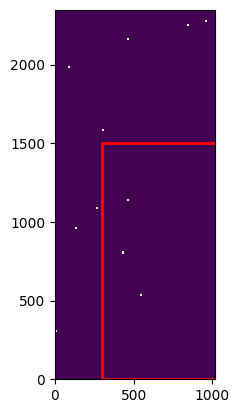

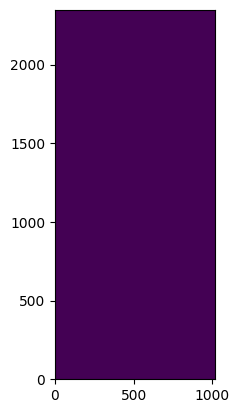

In [22]:
# Plotting one flat frame as an example (highlighting the region of interest) and one mask for high counts
# flat frame
%matplotlib inline
b = flat_array[0]
fig, ax = plt.subplots(1, 1)
ax.imshow(b, origin='lower', vmin=np.median(b)-2*np.std(b), vmax =np.median(b)+2*np.std(b))

# rectangle of interest
center = PixCoord((xmin+xmax)/2, (ymin+ymax)/2)
width = xmax-xmin
height = ymax-ymin
reg = RectanglePixelRegion(center=center, width=width, height=height)
patch = reg.as_artist(facecolor='none', edgecolor='red', lw=2)
ax.add_patch(patch)

# high-counts mask
plt.figure()
c = flat_masks_array[0]
c.reshape(b.shape)
plt.imshow(c, origin='lower')

# Lamp has a shape: need to fit a 2D Polynomial

Before combining the flat frames into a single Master Flat, it is important to fit a 2D polynomial in order to trace the shape of the lamp in the cross-dispersion direction. 

The dispersion direction is the one along which photons of different wavelengths disperse in a spectrograph (y axis). The cross-dispersion direction is simply the one perpendicular to the former.

Below we fit each flat frame with a 2D polynomial and plot the:

-> the flat frame

-> the best polynomial model

-> the relative residual, i.e. (data - model) / data

-> the normalized flat, i.e. data / model

The last frames plotted (last column on the right) is what we want to combine to obtain the Master Flat becuase they have been corrected for the lamp's shape and they only contain the information on the pxel-to-pixel sensitivity variations.

In [27]:
# Fitting each flat frame with a 2d polynomial
from scipy import interpolate
import warnings
from astropy.modeling import models, fitting

# If you want to adjust region of interest where to model the flats:
xmin, xmax, ymin, ymax = 300, 1800, 0, 1500

norm_flat_array = [] # define array of normalized flat frames

# Measure time for modeling the flat
start_time = timeit.default_timer()

for flat in flat_array:

    x, y = np.mgrid[xmin:xmax,ymin:ymax] # define grid for the region of interest
    z = np.transpose(flat[ymin:ymax,xmin:xmax]) # frame data: y-axis is the first and x-axis is the second  

    print(x.shape)
    print(y.shape)
    print(z.shape)

    #p_init = models.Polynomial2D(degree=7)
    p_init = models.Chebyshev2D(x_degree=7, y_degree=7)    # for a better fit use Chebyshev Polynomials
    fit_p = fitting.LinearLSQFitter()
    p = fit_p(p_init, x, y, z) # fitting the region of interest
    
    x_frame, y_frame = np.mgrid[0:xdim, 0:ydim] # define grid for the whole frame
    poly = np.transpose(p(x_frame, y_frame)) # go back to axis order of original matrix 
    resid_rel = (flat - poly) / flat
    norm = flat / poly

    # Plot data, model, residual and normalized frame
    plt.figure(figsize=(10, 2))
    plt.subplot(1, 4, 1)
    plt.imshow(flat, origin='lower', vmin=np.median(flat)-2*np.std(flat), vmax=np.median(flat)+2*np.std(flat))
    plt.title("Flat")
    plt.subplot(1, 4, 2)
    plt.imshow(poly, origin='lower', vmin=np.median(flat)-2*np.std(flat), vmax=np.median(flat)+2*np.std(flat))
    plt.title("Model")
    plt.subplot(1, 4, 3)
    plt.imshow(resid_rel, origin='lower', vmin=0, vmax=2)
    plt.title("Relative Residual")
    plt.subplot(1, 4, 4)
    plt.imshow(norm, origin='lower', vmin=0, vmax=2)
    plt.title("Normalized flat")
    
    norm_flat_array.append(norm)
    
    print("2D Polynomial fit of the region of interest...")
    print("Normalized flat frame created with shape ", norm.shape)
          
elapsed = timeit.default_timer() - start_time
print("\nTotal time taken for modeling the flat frames: ", "{:.2f}".format(elapsed), "seconds")
print("Time per frame: ", "{:.2f}".format(elapsed / len(flat_array)))

(1500, 1500)
(1500, 1500)
(720, 1500)


ValueError: x, y and z should have the same shape

# Combining the normalized flat frames into the Master Flat

How to combine the bias frames into a single Master Bias? 

Same as for Master Bias! We will use two methods:

1) compute for each pixel the mean value along the stack of bias frames

2) compute for each pixel the median value along the stack of bias frames

We will then create a fits file for the Master Flat obtained with the "mean" method.

<IPython.core.display.Javascript object>


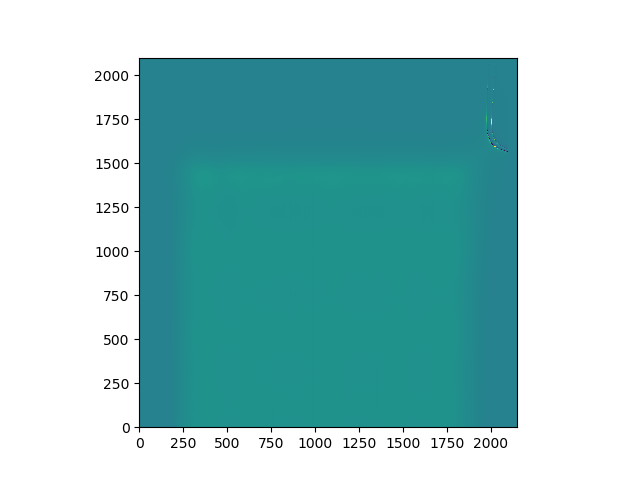

<IPython.core.display.Javascript object>


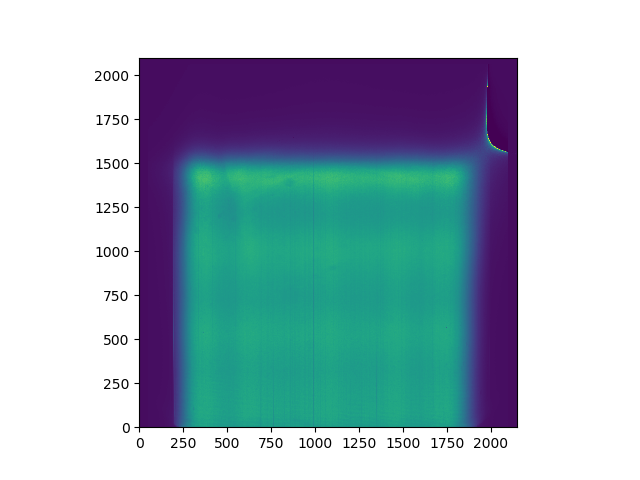

In [6]:
# Computing the master flat using a function defined in data_reduction.py module
# Two methods of combination are available: (1) mean or (2) median

# need norm_flat_array

master_flat1 = get_master(norm_flat_array, method="mean", n_clip=2)
master_flat2 = get_master(norm_flat_array, method="median", n_clip=2)

b = master_flat1
plt.figure()
plt.imshow(b, origin='lower', vmin=np.median(b)-2*np.std(b), vmax =np.median(b)+2*np.std(b))

c = master_flat2
plt.figure()
plt.imshow(c, origin='lower', vmin=np.median(c)-2*np.std(c), vmax =np.median(c)+2*np.std(c))

# Creating a fits file for the master flat obtained with the average
hdu = fits.ImageHDU(master_flat1)

hdr = fits.Header()
now = datetime.datetime.now()
now_string = now.strftime("%Y-%m-%d %H:%M:%S")
hdr['COMMENT'] = "Master flat frame (average of flat frames) obtained on " + now_string
hdr['IMAGETYP'] = 'MASTER FLAT'
empty_primary = fits.PrimaryHDU(header=hdr)

hdul = fits.HDUList([empty_primary, hdu])
master_name = path2data + '/master_flat_mean.fits'
hdul.writeto(master_name, overwrite=True)

# Dividing the object frames by the Master Flat

The Master Flat rapresents the best estimate of the sensitivity factor of each pixel. We want to divide all other frames that are not bias or flat frames by the Master Flat pixel-by-pixel.

Below we do that, leaving a comment in the header of each newly created fits file. The original files are kept unchanged. The new files are named with the suffix "_b". 

We print below the name of the new flat-normalized files and their image type.

In [7]:
# Subtracting the master flat (mean) from all other frames that are not flat frames

hdul_master = fits.open(path2data+'/master_flat_mean.fits')

for file in fnames:
    hdul = fits.open(file)
    
    if 'FLAT_DIV' in hdul[0].header:  # if flat has been divided already we skip to the next frame
        continue 
    
    imtyp = hdul[0].header['IMAGETYP']
    if imtyp == 'WAVE,LAMP' or imtyp == 'OBJECT':
        
        hdul[1].data = hdul[1].data / hdul_master[1].data
        print("Master flat divided, frame", file, "of image type:\n", hdul[0].header['IMAGETYP'])
        
        comment = "Master flat divided on: "
        now = datetime.datetime.now()
        comment += now.strftime("%Y-%m-%d %H:%M:%S")
        comment += " using master flat file " + master_name       
        hdul[0].header['HISTORY'] = comment
        hdul[0].header['COMMENT'] = comment
        hdul[0].header['FLAT_DIV'] = 'Yes'
        
        new_file_name = file.replace(".fits", "_f.fits")
        hdul.writeto(new_file_name, overwrite=True)
        print("New fits file created for the flat-normalized frame:", new_file_name, "\n")
    
    hdul.close()

hdul_master.close()

Master flat divided, frame /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130145_b.fits of image type:
 OBJECT
New fits file created for the flat-normalized frame: /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130145_b_f.fits 

Master flat divided, frame /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130155_b.fits of image type:
 OBJECT
New fits file created for the flat-normalized frame: /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130155_b_f.fits 

Master flat divided, frame /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130144_b.fits of image type:
 OBJECT
New fits file created for the flat-normalized frame: /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130144_b_f.fits 

Master flat divided, frame /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130146_b.fits of image type:
 WAVE,LAMP
New fits file created for the flat-normalized frame: /home/masi1109/Documents/PhD/ObsII/not2mattia/ALAe130146_b_f.fits 

Master flat divided, frame /home/masi1109/Documents/PhD/O